##### Copyright 2018 The TensorFlow Authors.

# Neural style transfer

# Customized training

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
....................................................................................................tf.Tensor([32452680.], shape=(1,), dtype=float32)


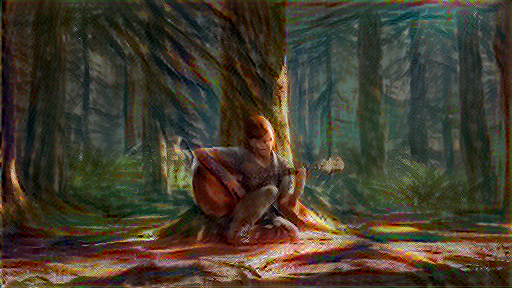

Train step: 100
....................................................................................................tf.Tensor([27297320.], shape=(1,), dtype=float32)


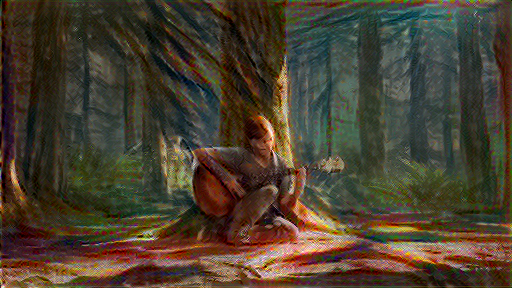

Train step: 200
....................................................................................................tf.Tensor([25780002.], shape=(1,), dtype=float32)


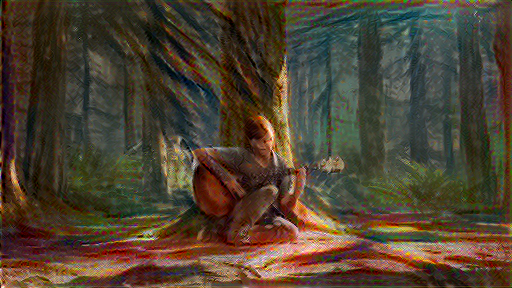

Train step: 300
....................................................................................................tf.Tensor([25031228.], shape=(1,), dtype=float32)


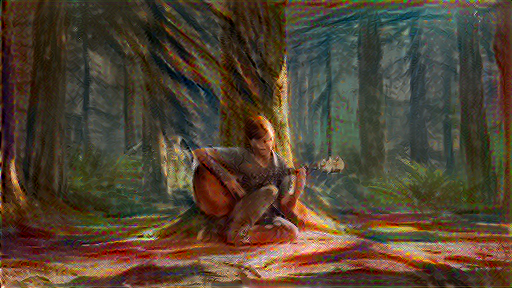

Train step: 400
....................................................................................................tf.Tensor([24640128.], shape=(1,), dtype=float32)


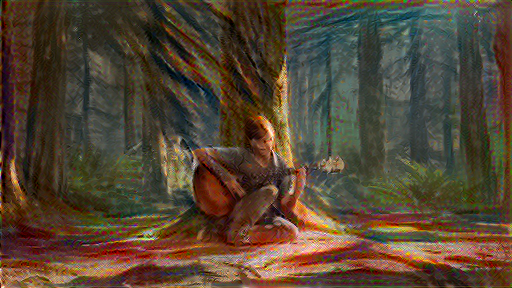

Train step: 500
....................................................................................................tf.Tensor([24079116.], shape=(1,), dtype=float32)


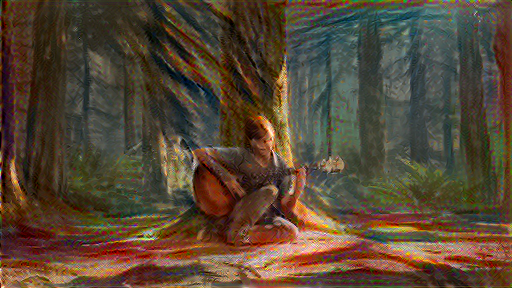

Train step: 600
....................................................................................................tf.Tensor([23733708.], shape=(1,), dtype=float32)


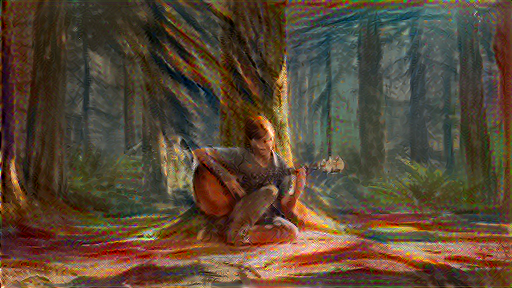

Train step: 700
....................................................................................................tf.Tensor([23581708.], shape=(1,), dtype=float32)


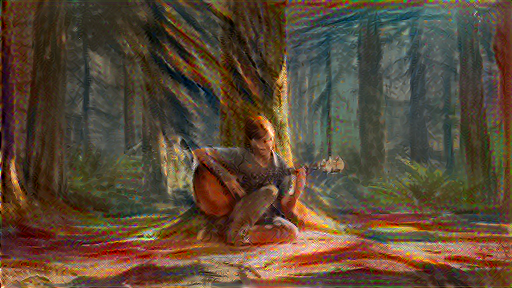

Train step: 800
....................................................................................................tf.Tensor([23463474.], shape=(1,), dtype=float32)


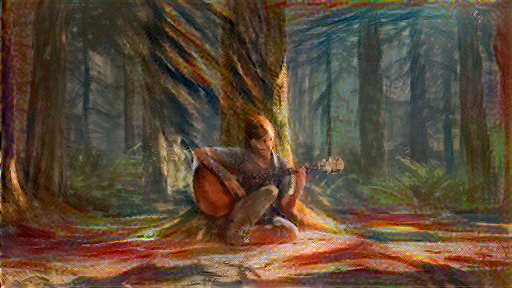

Train step: 900
....................................................................................................tf.Tensor([23151226.], shape=(1,), dtype=float32)


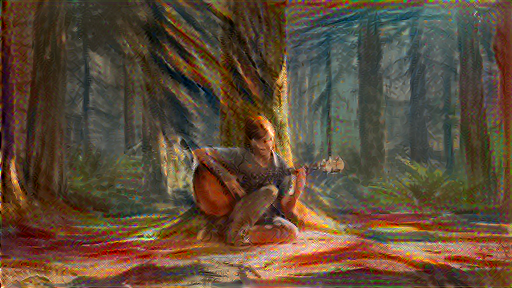

Train step: 1000
....................................................................................................tf.Tensor([23189902.], shape=(1,), dtype=float32)


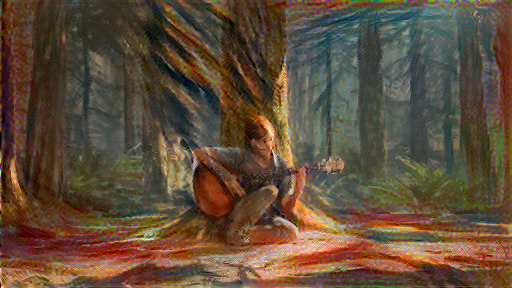

Train step: 1100
....................................................................................................tf.Tensor([22922638.], shape=(1,), dtype=float32)


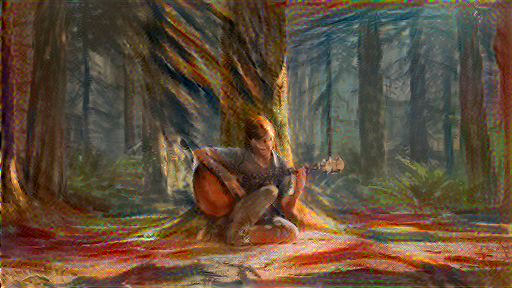

Train step: 1200
....................................................................................................tf.Tensor([22677138.], shape=(1,), dtype=float32)


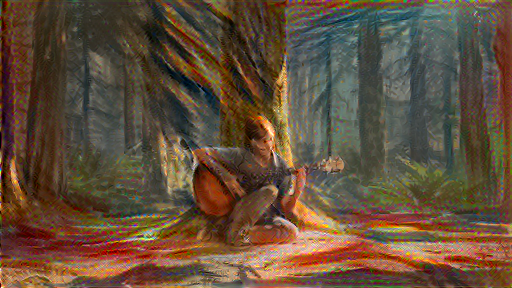

Train step: 1300
....................................................................................................tf.Tensor([22627616.], shape=(1,), dtype=float32)


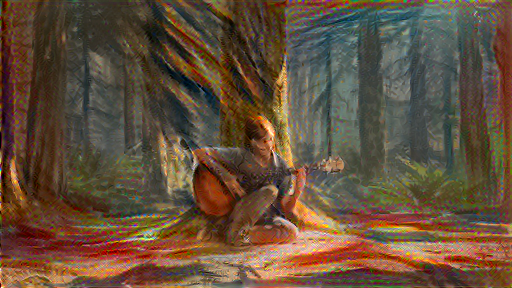

Train step: 1400
....................................................................................................tf.Tensor([22475964.], shape=(1,), dtype=float32)


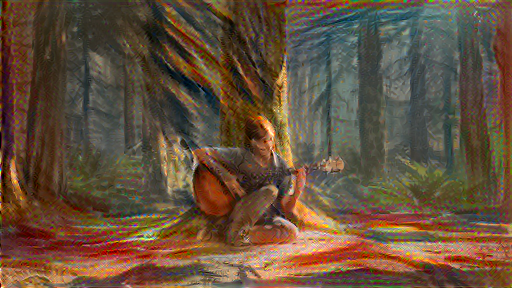

Train step: 1500


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

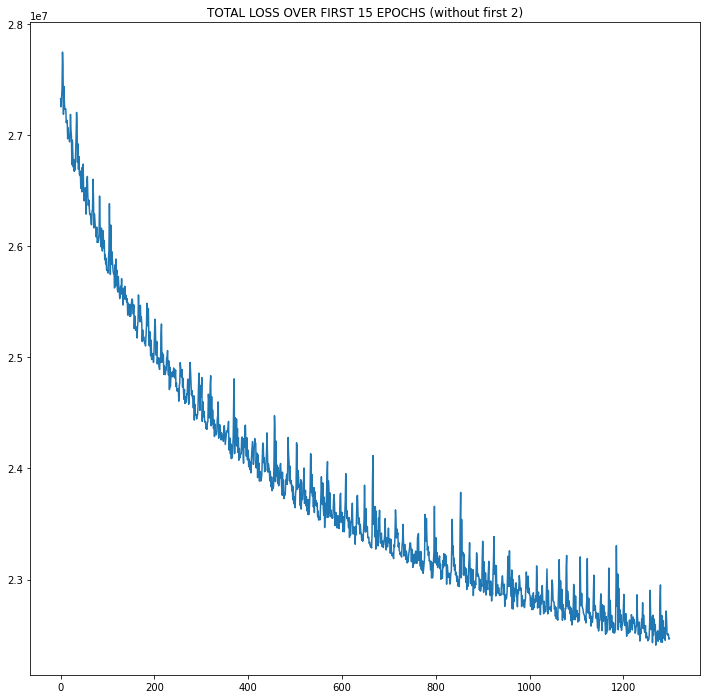

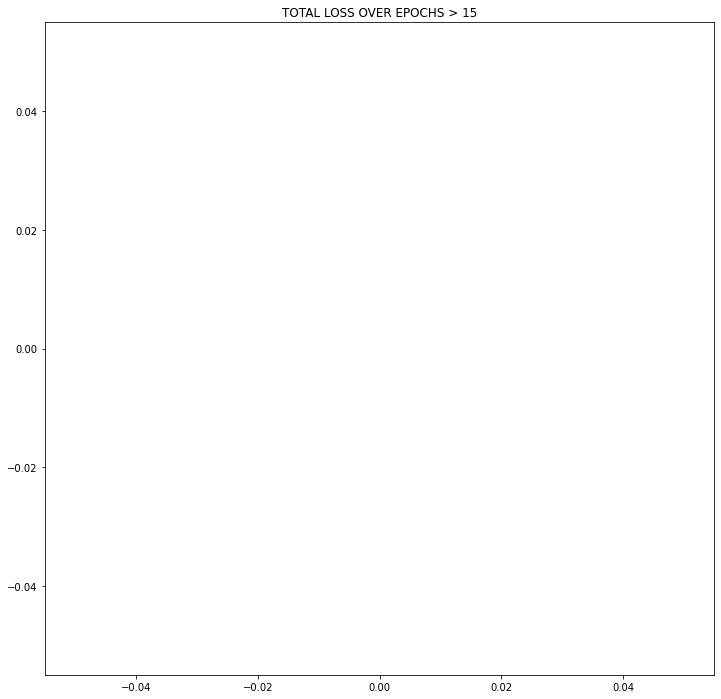

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 864x864 with 0 Axes>

In [ ]:
import os
import tensorflow as tf
# Loada dei modelli compressi da tf
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import requests

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
 





# classe con utils functions
class Utils():

  #trasforma un tensore in un oggetto immagine (Pil.Image)
  def tensor_to_image(self,tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
    return PIL.Image.fromarray(tensor)
  # ritorna un oggetto immagine caricato da un path datogli, setta la massima dimensione a 512
  def load_img(self,path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img
  # printa a schermo l'immagine datagli
  def imshow(self,image, title=None):
    if len(image.shape) > 3:
      image = tf.squeeze(image, axis=0)

    
    if title:
      plt.title(title)
  def clip_0_1(self,image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)



from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')







class ModelStructure(tf.keras.models.Model):
  def __init__(self,util):
    super(ModelStructure, self).__init__()
    # questi parametri sono settati di default con l'inizializzazione del costruttore
    # possono essere modificati duranti il training
    self.util = util
    url = 'https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg'
    response = requests.get(url)
    file = open("Tuebingen_Neckarfront.jpg", "wb")
    file.write(response.content)
    file.close()
    self.content_path = "Tuebingen_Neckarfront.jpg"
    self.style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
    self.training_image_path= "Tuebingen_Neckarfront.jpg"
    self.vgg = None
    self.pool = 'avg'
    self.vgg =  self.vgg_layers(['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1','block4_conv2','block5_conv1','block5_conv2'], self.pool)
    self.style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
    self.content_layers = ['block4_conv2']
    self.num_style_layers = len(self.style_layers)
    self.num_content_layers = len(self.content_layers)
    self.opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    self.content_image = tf.Variable(util.load_img(self.content_path))
    self.style_image = tf.Variable(util.load_img(self.style_path))
    self.image = self.content_image
    self.style_weight=1e-2
    self.content_weight=1e4
    self.total_variation_weight=50
    

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [self.gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}
  
  def printVggLayers(self):
    for layer in self.content_layers:
      print(layer)
    for layer1 in self.style_layers:
      print(layer1)

  def set_content_image(self,image_path):
    self.content_path = image_path
    self.content_image = tf.Variable(self.util.load_img(image_path))
  def set_style_image(self,image_path):
    self.style_path = image_path
    self.style_image = tf.Variable(self.util.load_img(image_path))
  def set_training_image(self,image_path):
    self.training_image_path=image_path
    #training_image_path="/content/gdrive/MyDrive/rumore_bianco.jpg"
    #img = tf.io.read_file(training_image_path)
    self.image = tf.Variable(self.util.load_img(image_path))
    
    
  #ritorna un modello rispetto agli output dati in layer names
  def vgg_layers(self,layer_names, pool):
    if pool=='max':
      self.vgg =  tf.keras.applications.VGG19(include_top=False, weights='imagenet') #max pooling is default in vgg19
    elif pool=='avg':
      self.vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet', pooling= pool)# carica vgg senza i fully connected layers finali (vgg usata per la classification)
    self.vgg.trainable = False
    outputs = [self.vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([self.vgg.input], outputs)
    return model
  
  def set_loss_weights(self,style_weight, content_weight, variation_weight):
    self.style_weight = style_weight
    self.content_weight = content_weight
    self.total_variation_weight=variation_weight

  def set_vgg_layers(self,style_layers, content_layers, pool):
    self.num_style_layers = len(style_layers)
    self.num_content_layers = len(content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.vgg = self.vgg_layers(style_layers+content_layers, pool)
  
  def set_optimizer(self,optimizer,learning_rate,momentum,beta_1, beta_2, initial_accumulator_value, epsilon, rho):
    if optimizer == 'ADAM':
      self.opt = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2 = beta_2, epsilon=epsilon)
    elif optimizer == 'ADAGRAD': 
      self.opt = tf.keras.optimizers.Adagrad(learning_rate=learning_rate, initial_accumulator_value=initial_accumulator_value,epsilon=epsilon)
    elif optimizer == 'RMSPROP':
      self.opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate,rho=rho, momentum=momentum, epsilon=epsilon)
    elif optimizer == 'ADADELTA':
      self.opt = tf.keras.optimizers.Adadelta(learning_rate=learning_rate, rho=rho, epsilon=epsilon)
    elif optimizer == 'ADAMAX':
      self.opt = tf.keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

  # computa la gram matrix per lo style error
  def gram_matrix(self,input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)
  
  def style_content_loss(self,outputs, style_targets, content_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean(tf.square(style_outputs[name]-style_targets[name])) 
                           for name in style_outputs.keys()])
    style_loss *= self.style_weight / self.num_style_layers

    content_loss = tf.add_n([tf.reduce_mean(tf.square(content_outputs[name]-content_targets[name])) 
                             for name in content_outputs.keys()])
    content_loss *= self.content_weight / self.num_content_layers
    loss = style_loss + content_loss
   
    return loss 




@tf.function()
def train_step(model,image, style, content):
  with tf.GradientTape() as tape:
    outputs = model(image)
    loss = model.style_content_loss(outputs,style,content)
    loss += model.total_variation_weight*tf.image.total_variation(image)
    
  grad = tape.gradient(loss, image)
  model.opt.apply_gradients([(grad, image)])
  image.assign(util.clip_0_1(image))
  return loss



def model_training_and_output(epochs, steps_per_epoch, model):
  step = 0
  image = tf.Variable(model.util.load_img(model.training_image_path))
  model.set_content_image(model.content_path)
  model.set_style_image(model.style_path)
  style = model(model.style_image)['style']
  content = model(model.content_image)['content']
  losses=[]
  step=0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      
      
      loss = train_step(model,image, style,content)
      losses=np.append(losses, loss[0])
      step += 1
      print(".", end='')
    #display.clear_output(wait=True)
    print(loss)
    display.display(model.util.tensor_to_image(image))
    print("Train step: {}".format(step))
  lo1=losses[200:1499]  
  plt.plot(lo1)
  plt.title('TOTAL LOSS OVER FIRST 15 EPOCHS (without first 2)')
  plt.savefig('losses1.png')
  file_name1 = 'losses1.png'
  files.download(file_name1)
  plt.show() 
  lo2=losses[1500:]
  plt.plot(lo2)
  plt.title('TOTAL LOSS OVER EPOCHS > 15')
  plt.show() 
  plt.savefig('losses2.png')
  file_name2 = 'losses2.png'
  files.download(file_name2)
  return image



####FINE SETUP








# 4.3.1

util = Utils()
model = ModelStructure(util) 

  # cambio dei settaggi, solo per l'optimizer e i relativi parametri associati
optimizer = 'ADAM' #@param["ADAM", "ADAMAX" , "ADAGRAD", "ADADELTA", "ADAGRAD", "SGD", "RMSPROP"]
lr = 0.007 #@param {type:"number"}
momentum = 0.9 #@param {type:"slider", min:0, max:1, step:0.01}
BETA1 = 0.9 #@param {type:"slider", min:0, max:1, step:0.01}
BETA2 = 0.9 #@param {type:"slider", min:0, max:1, step:0.01}
initial_accumulator_value = 0.01 #@param {type:"slider", min:0, max:1, step:0.01}
epsilon = 1e-7 
rho = 0.95 
epochs = 15 #@param {type:"number"}
steps_per_epoch = 100 #@param {type:"slider", min:10, max:1000, step:10}
  
model.set_optimizer(optimizer,lr,momentum,BETA1,BETA2,initial_accumulator_value,epsilon,rho)

  # per cambiare i pesi delle loss posso fare
style_weight = 1e-1 #@param {type:"number"}
content_weight = 100 #@param {type:"number"}
variational_weight =  10#@param {type:"number"}
model.set_loss_weights(style_weight,content_weight,variational_weight)
  

  # posso cambiare le immagini
style_url = 'https://www.liveauctioneers.com/news/wp-content/uploads/2021/02/Skrik_Nasjonalgalleriet_Oslo_10_2018_3930-1.jpg' #@param {type:"raw"}
response = requests.get(style_url)
file = open("femme_nue.jpg", "wb")
file.write(response.content)
file.close()
model.set_style_image("femme_nue.jpg")
  #c'è anche per il content image
content_url = 'https://images3.alphacoders.com/106/thumb-1920-1065466.png' #@param {type:"raw"}
response = requests.get(content_url)
file = open("Tuebingen_Neckarfront.jpg", "wb")
file.write(response.content)
file.close()
model.set_content_image("Tuebingen_Neckarfront.jpg")
  #training image
training_image = tf.random.uniform(model.content_image.shape, minval=0, maxval=254, dtype=tf.dtypes.float32, seed=None, name=None)
model.util.tensor_to_image(training_image).save("noise.jpg")
starting_image = 'original' #@param["noisy" , "original"]
if starting_image == 'noisy':
  training_image_path="noise.jpg"
else:
  training_image_path="Tuebingen_Neckarfront.jpg"
model.set_training_image(training_image_path)

  #posso anche cambiare i layers
content_layers = ['block4_conv2'] #@param {type:"raw"}
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'] #@param {type:"raw"}
pooling='avg' #@param["avg" , "max"]
model.set_vgg_layers(style_layers, content_layers, pooling)
  
  #training procedure
image=model_training_and_output(epochs,steps_per_epoch,model)


file_name = '4.3(AVG).png'
model.util.tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)